# Previsão de faturamento - Modelo autorregressivo ajustado ao faturamento total

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento total mês a mês, somando todos os produtos

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelos
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)
fat_total = tswide.sum(axis = 'columns').dropna()

In [3]:
fat_total

date
2009-12-01    1.006195e+09
2010-01-01    9.993524e+08
2010-02-01    1.000041e+09
2010-03-01    9.905806e+08
2010-04-01    9.947466e+08
                  ...     
2021-06-01    2.086224e+09
2021-07-01    2.073233e+09
2021-08-01    2.101590e+09
2021-09-01    2.179518e+09
2021-10-01    2.193340e+09
Freq: MS, Length: 143, dtype: float64

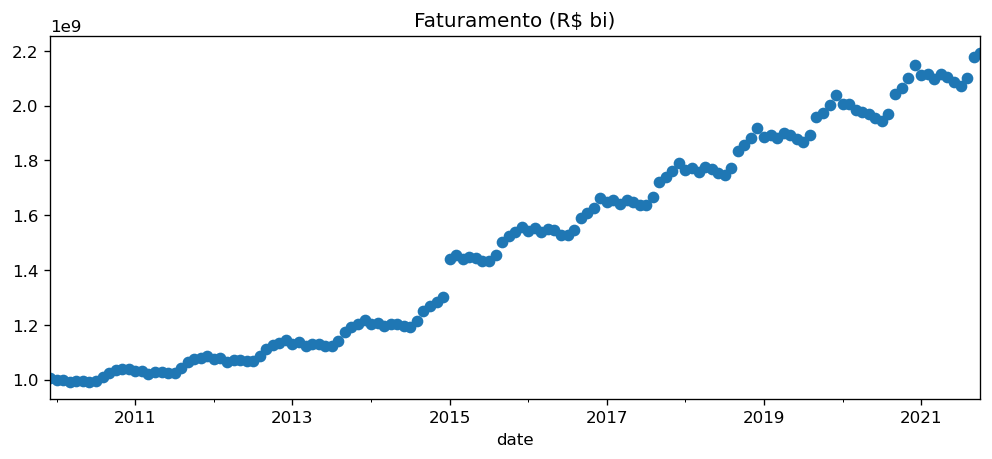

In [4]:
fat_total.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

## Modelo autorregressivo - Faturamento total

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

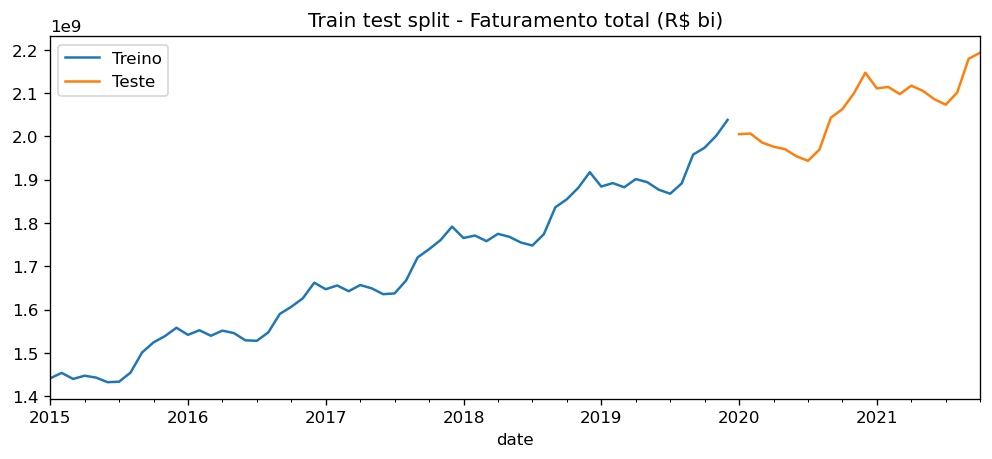

In [5]:
# excluindo o período pré-2015
train_begin = '2015-01-01'
test_begin = '2020-01-01'

total_train = fat_total[train_begin:test_begin].iloc[:-1]
total_test = fat_total[test_begin:]

fig = plt.figure()
total_train.plot(label = 'Treino')
total_test.plot(label = 'Teste')

plt.title('Train test split - Faturamento total (R$ bi)')
plt.legend()
plt.show()

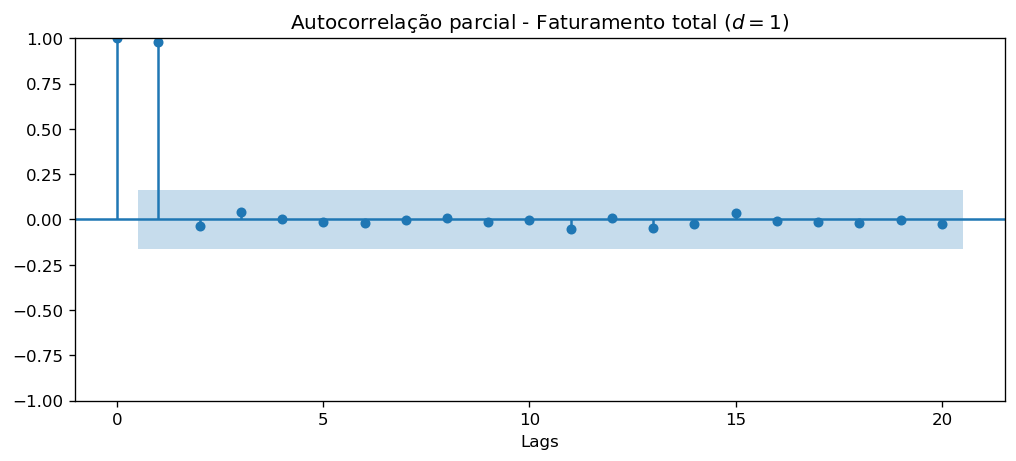

In [6]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_total, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento total ($d = 1$)")
plt.show()

In [7]:
arimas = {}
arimas['total'] = auto_arima(
    y = total_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True
    #alpha = 0.05
)

In [8]:
arimas['total'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -793.399
Date:                            Tue, 16 Nov 2021   AIC                           1588.799
Time:                                    20:24:33   BIC                           1590.649
Sample:                                         0   HQIC                          1589.495
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.041e+13   2.46e+12      8.313      0.000    1.56e+13    2.52e+13
===================================================================================
Ljung-Box (L1) (Q):                   3.83   Jarque-Bera (JB):                 6.52
Prob(Q):                              0.05   Prob(JB):                         0.04
Heteroskedasticity (H):               0.57   Skew:                             0.59
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

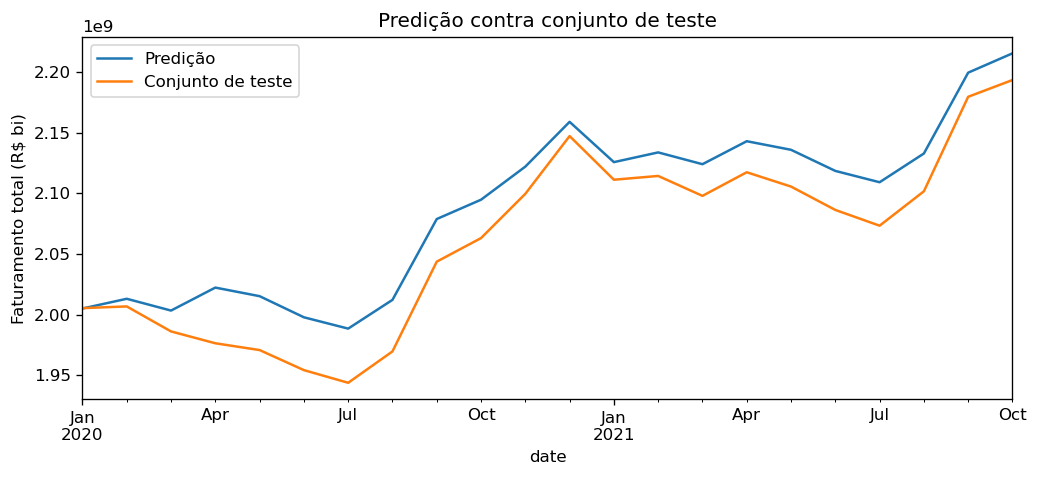

In [9]:
n_test_periods = total_test.shape[0]
arr_preds = arimas['total'].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = test_begin, periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
total_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [10]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds
)

metricas = dict(
    total = dict(
        mape = smape(**kwargs_total),
        rmse = np.sqrt(smse(**kwargs_total)),
        mae = smae(**kwargs_total)
    )
)

mape = metricas['total']['mape']
rmse = metricas['total']['rmse']
mae = metricas['total']['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 1.341%
RMSE: 3.015e+07
 MAE: 2.740e+07
